In [1]:
options(warn = -1, tidyverse.quiet = T)

suppressPackageStartupMessages(library(tidyverse, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(cowplot, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(mgcv, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(broom, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(arrow, warn.conflicts = F, quietly = T))

options(readr.show_col_types = FALSE)

In [2]:
full_df <- read_tsv_arrow("data/full_summary.tsv.zst") %>%
    mutate(
        i = str_extract(path, "(?<=sim_)[0-9]+"),
        h = str_extract(path, "(?<=h_)[\\.0-9]+"),
        s = str_extract(path, "(?<=s_)[\\.0-9]+"),
        p = str_extract(path, "(?<=p_)[\\.0-9]+"),
        across(c(i, h, s, p), as.double),
    ) %>%
    distinct %>%
    mutate(
        missingness = if_else(
            str_detect(method, "m_[0-9]+"), 
            str_extract(method, "(?<=m_)([0-9\\.]+)") %>% as.double, 
            0
        ),
        variance = if_else(
            str_detect(method, "v_[0-9]+"),
            str_extract(method, "(?<=v_)([0-9\\.]+)") %>% as.double,
            0
        ),
        F1 = 2 * TP / (2 * TP + FP + FN),
    )

full_df %>% dim

full_df %>% head(2)

[1] 1560000      22

phenotype,method,P,N,TP,TN,FP,FN,total,bias,⋯,sensitivity,specificity,path,i,h,s,p,missingness,variance,F1
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Trait_14,liability,593,1491,106,1423,68,487,2084,0.0007791386,⋯,0.1787521,0.9543930,data/simulations/sim_29_h_0.1_s_0.5_p_0.7/summary/liability.tsv,29,0.1,0.5,0.7,0,0,0.2764016
Trait_44,liability,992,1516,410,1456,60,582,2508,-0.0004492340,⋯,0.4133065,0.9604222,data/simulations/sim_29_h_0.1_s_0.5_p_0.7/summary/liability.tsv,29,0.1,0.5,0.7,0,0,0.5608755


# Main plot

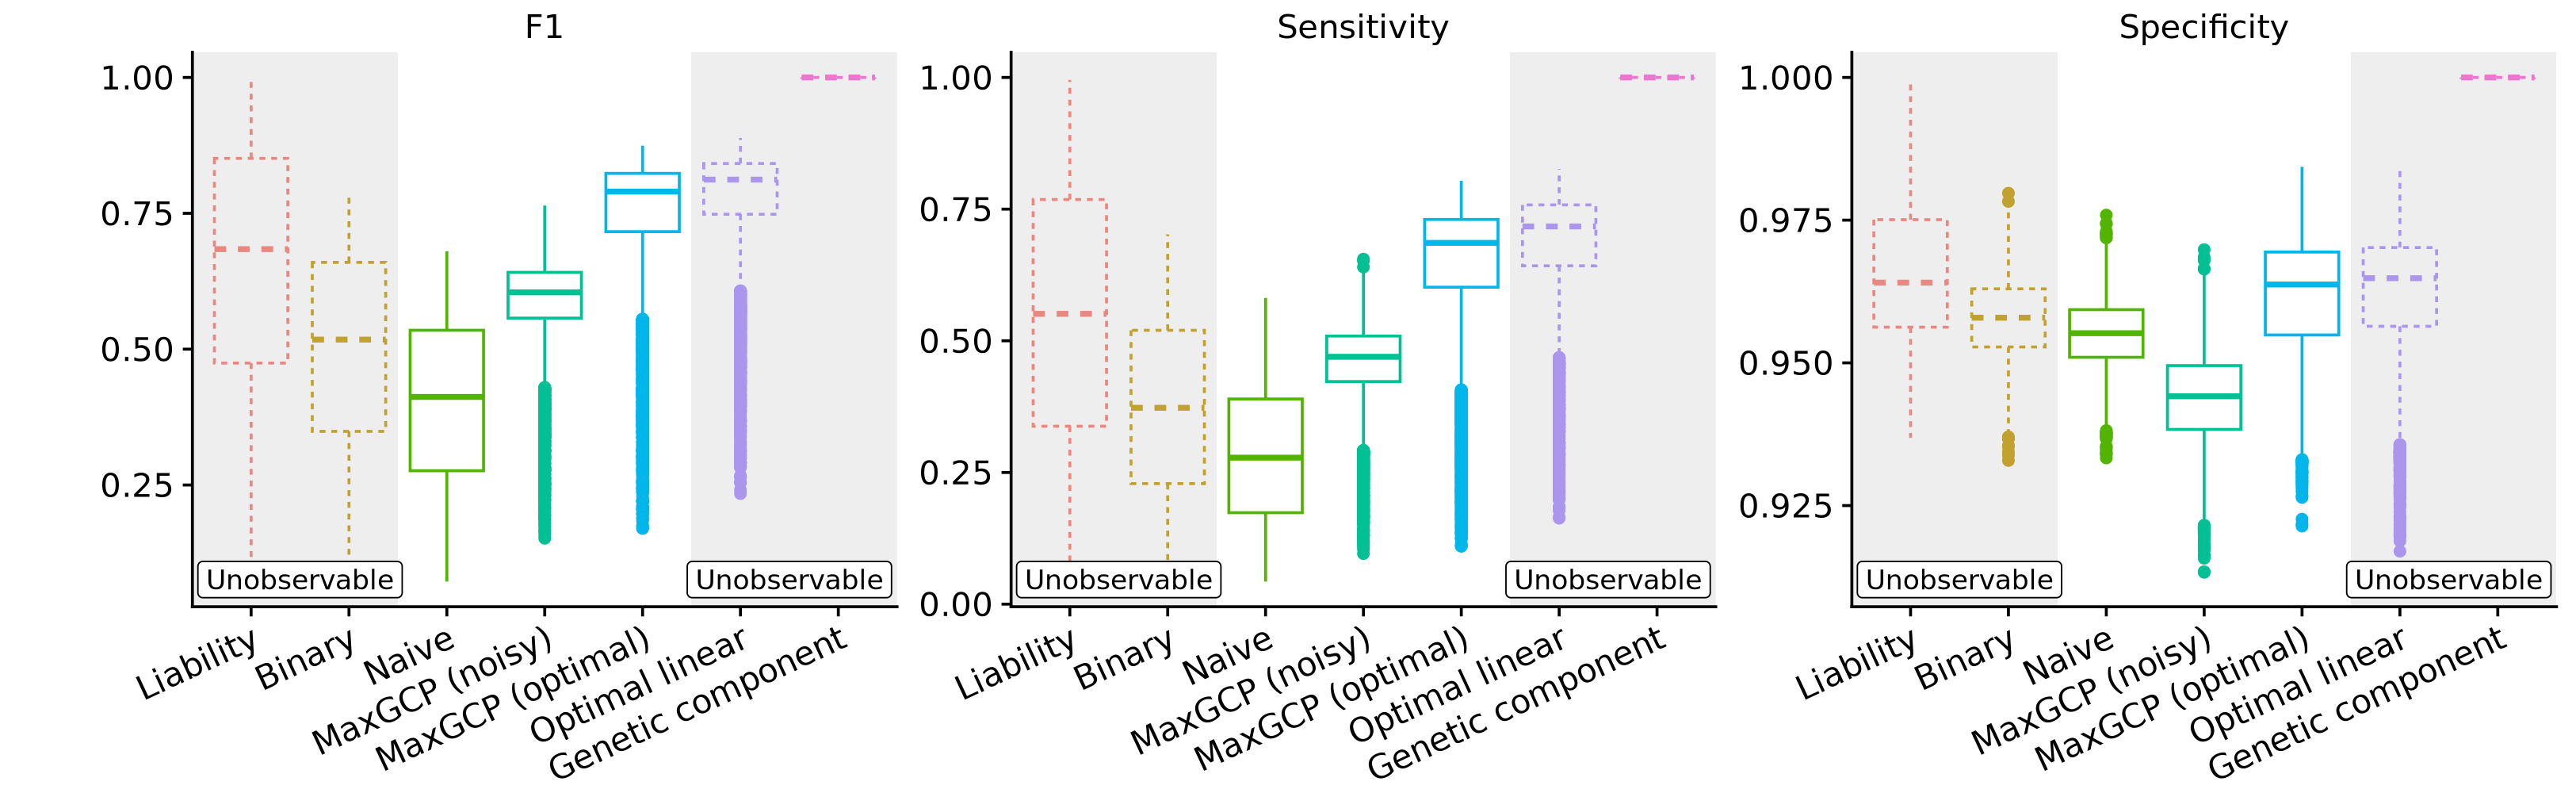

In [3]:
options(repr.plot.width = 13, repr.plot.height = 4, repr.plot.res = 250)

main_plot <- full_df %>%
    mutate(
        method = method %>%
            recode_factor(
                liability = "Liability",
                `binary_m_0.0` = "Binary",
                `binary_m_0.25` = "Naive",
                `maxgcp_m_0.25_v_0.05` = "MaxGCP (noisy)",
                `maxgcp_m_0.25_v_0.0` = "MaxGCP (optimal)",
                optimal = "Optimal linear",
                g = "Genetic component",
            ),
        dashed = method %in% c("Liability", "Binary", "Optimal linear", "Genetic component"),
    ) %>%
    filter(!str_detect(method, "_")) %>%
    filter(h == 0.5, s == 0.9, p == 0.0) %>%
    distinct %>%
    rename(Sensitivity = sensitivity, Specificity = specificity) %>%
    pivot_longer(c(F1, AUROC, Sensitivity, Specificity), names_to = "metric", 
                 values_to = "metric_value") %>%
    filter(metric != "AUROC") %>%
    ggplot(aes(x = method, y = metric_value, color = method)) +
    geom_boxplot(aes(linetype = dashed)) +
    annotate(
        geom = "rect", xmin = -Inf, xmax = 2.5, ymin = -Inf, ymax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(
        geom = "rect", xmin = 5.5, xmax = Inf, ymin = -Inf, ymax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(geom = "label", x = 1.5, y = -Inf, label = "Unobservable", hjust = 0.5, vjust = -0.25, size = 3.5) +
    annotate(geom = "label", x = 6.5, y = -Inf, label = "Unobservable", hjust = 0.5, vjust = -0.25, size = 3.5) +
    ylab("Metric value") +
    theme_cowplot() +
    facet_wrap(vars(metric), scales = "free_y") +
    theme(
        axis.text.x = element_text(angle = 25, hjust = 1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        legend.position = "none",
        strip.background = element_blank(),
        plot.margin = margin(0, 0.25, 0, 1.25, "cm")
    )    

save_plot("img/main.all.png", main_plot, base_width = 13, base_height = 4, 
          dpi = 400, bg = "white")

main_plot

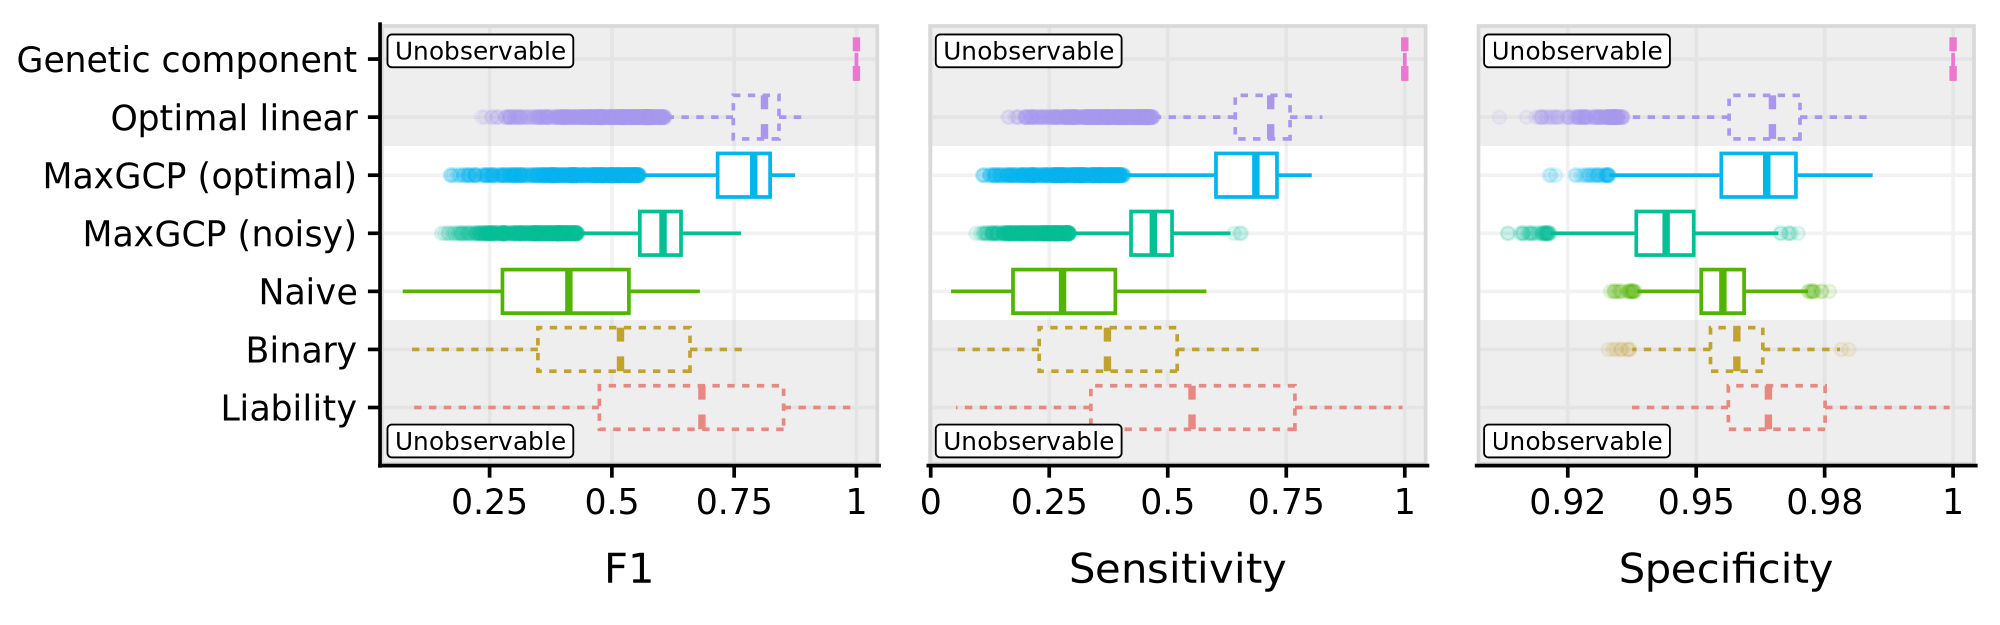

In [4]:
options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 250)

main_plot <- full_df %>%
    mutate(
        method = method %>%
            recode_factor(
                liability = "Liability",
                `binary_m_0.0` = "Binary",
                `binary_m_0.25` = "Naive",
                `maxgcp_m_0.25_v_0.05` = "MaxGCP (noisy)",
                `maxgcp_m_0.25_v_0.0` = "MaxGCP (optimal)",
                optimal = "Optimal linear",
                g = "Genetic component",
            ),
        dashed = method %in% c("Liability", "Binary", "Optimal linear", "Genetic component"),
    ) %>%
    filter(!str_detect(method, "_")) %>%
    filter(h == 0.5, s == 0.9, p == 0.0) %>%
    distinct %>%
    rename(Sensitivity = sensitivity, Specificity = specificity) %>%
    pivot_longer(c(AUROC, F1, Sensitivity, Specificity), names_to = "metric", 
                 values_to = "metric_value") %>%
    select(method, metric, metric_value, dashed) %>%
    filter(metric != "AUROC") %>%
    ggplot(aes(y = method, x = metric_value, color = method, linetype = dashed)) +
    geom_boxplot(outlier.alpha = 0.1) +
    facet_wrap(vars(metric), scales = "free_x", switch = "x") +
    theme_cowplot() +
    panel_border() +
    background_grid(color.major = "grey95", color.minor = "grey95") +
    scale_x_continuous(labels = function(x) x %>% signif(2) %>% as.character) +
    theme(
        legend.position = "none",
        axis.title = element_blank(),
        strip.background = element_blank(),
        strip.placement = "outside",
        axis.text = element_text(size = 10),
        panel.spacing.x = unit(5, "mm")
    ) +
    annotate(
        geom = "rect", ymin = -Inf, ymax = 2.5, xmin = -Inf, xmax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(
        geom = "rect", ymin = 5.5, ymax = Inf, xmin = -Inf, xmax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(geom = "label", y = 0, x = -Inf, label = "Unobservable", hjust = -0.04, 
             vjust = -0.25, size = 2.5) +
    annotate(geom = "label", y = 7, x = -Inf, label = "Unobservable", hjust = -0.04, 
             vjust = 0.25, size = 2.5)

save_plot("img/main.all.horizontal.png", main_plot, base_width = 8, base_height = 2.5, 
          dpi = 400, bg = "white")

main_plot

# Simulation parameters plot

In [5]:
merged_df <- bind_rows(
    # Across heritability
    full_df %>%
        filter(s == 0.5, p == 0.0) %>%
        mutate(plot = "h2") %>%
        select(plot, method, x = h, F1, AUROC, sensitivity, specificity),
    # Across genetic correlation
    full_df %>%
        filter(h == 0.1, p == 0.0, s > 0) %>%
        mutate(plot = "rg") %>%
        select(plot, method, x = s, F1, AUROC, sensitivity, specificity),
    # Across missingness
    full_df %>%
        filter(h == 0.1, s == 0.5, p == 0) %>%
        mutate(
            plot = "missingness",
            method = method %>%
                str_replace(pattern = "_m_[0-9\\.]+", replacement = "") %>%
                recode(
                    liability = "Naive (liability)",
                    `binary` = "Naive (missingness)",
                    `maxgcp_v_0.05` = "MaxGCP (noisy)",
                    `maxgcp_v_0.0` = "MaxGCP (optimal)",
                    optimal = "Optimal linear",
                    g = "Genetic component",
                ),
        ) %>%
        select(plot, method, x = missingness, F1, AUROC, sensitivity, specificity),
    # Across variance in genetic covariance estimates
    full_df %>%
        filter(h == 0.1, s == 0.5, p == 0) %>%
        mutate(
            plot = "variance",
            method = method %>%
                str_replace(pattern = "_v_[0-9\\.]+", replacement = "") %>%
                recode(
                    liability = "Naive (liability)",
                    `binary_m_0.0` = "Naive (binary)",
                    `binary_m_0.25` = "Naive (missingness)",
                    `maxgcp_m_0.25` = "MaxGCP (noisy)",
                    optimal = "Optimal linear",
                    g = "Genetic component",
                ),
        ) %>%
        select(plot, method, x = variance, F1, AUROC, sensitivity, specificity) %>%
        bind_rows(filter(., method == "Naive (missingness)", x == 0) %>% mutate(x = 1.)),
) %>%
    mutate(
        method = method %>%
            recode(
                liability = "Naive (liability)",
                `binary_m_0.0` = "Naive (binary)",
                `binary_m_0.25` = "Naive (missingness)",
                `maxgcp_m_0.25_v_0.05` = "MaxGCP (noisy)",
                `maxgcp_m_0.25_v_0.0` = "MaxGCP (optimal)",
                optimal = "Optimal linear",
                g = "Genetic component",
            ) %>%
            factor(levels = c(
                "Genetic component", "Optimal linear", "Naive (liability)", "Naive (binary)", 
                "Naive (missingness)", "MaxGCP (noisy)", "MaxGCP (optimal)"
            )),
        dashed = if_else(
                method %in% c("Naive (liability)", "Naive (binary)", "Optimal linear", 
                              "Genetic component"),
                "Unobservable", "Observable"),
        plot = recode_factor(
            plot, h2 = "Heritability", rg = "Genetic correlation", 
            missingness = "Missingness", variance = "Variance"
        )
    ) %>%
    filter(!str_detect(method, "_")) 

In [6]:
plot_df <- merged_df %>%
    pivot_longer(c(F1, AUROC, sensitivity, specificity), names_to = "metric", values_to = "y") %>%
    nest(data = c(x, y)) %>%
    rowwise() %>%
    filter(pmin(nrow(distinct(data, x)), nrow(distinct(data, x))) >= 10) %>%
    mutate(
        model = gam(y ~ s(x, k = 10), data = data) %>% 
            augment(newdata = data.frame(x = seq(0, 1, length.out = 100))) %>% 
            list
    ) %>%
    ungroup %>%
    select(-data) %>%
    unnest(model)

In [7]:
const_rows <- expand_grid(
        plot = c("Missingness", "Variance"),
        method = c("Genetic component"),
        dashed = "Unobservable",
        metric = c("F1", "AUROC", "sensitivity", "specificity"),
        x = c(0.0, 1.0),
        .fitted = 1.0,
        .se.fit = 0.0
    ) %>%
    bind_rows(
        plot_df %>%
            filter(plot == "Variance", method == "MaxGCP (noisy)", x == 0) %>%
            mutate(method = "MaxGCP (optimal)") %>%
            bind_rows(mutate(., x = 1.0)),
        full_df %>%
            filter(method == "binary_m_0.25", h == 0.1, s == 0.5, p == 0.0) %>%
            pivot_longer(c(AUROC, F1, sensitivity, specificity), names_to = "metric", 
                         values_to = ".fitted") %>%
            group_by(metric) %>%
            summarize(.fitted = mean(.fitted)) %>%
            mutate(
                plot = "Variance",
                method = "Naive (missingness)",
                dashed = "Observable",
                x = 0.0,
                .se.fit = 0.0
            ) %>%
            bind_rows(mutate(., x = 1.0)) %>%
            select(plot, method, dashed, metric, x, .fitted, .se.fit)
    )

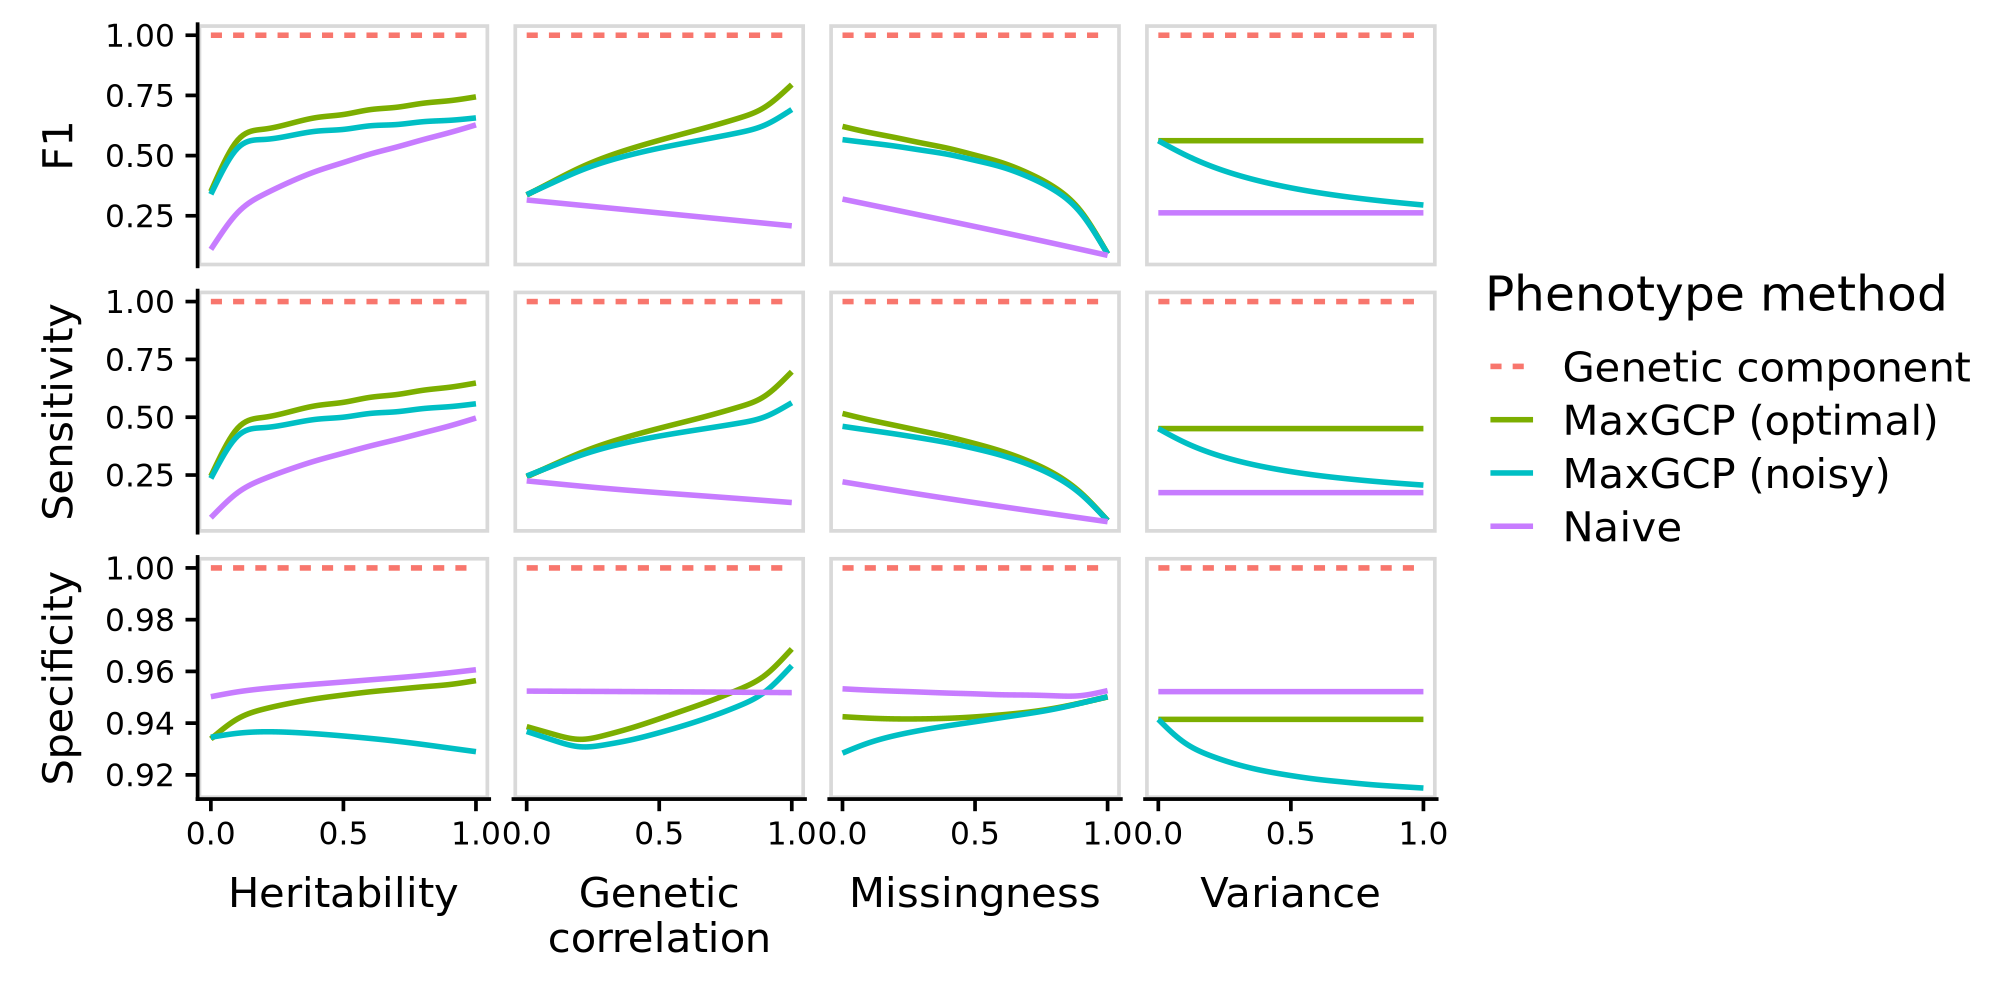

In [8]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

method_order <- c("Genetic component", "MaxGCP (optimal)", "MaxGCP (noisy)", "Naive")

parameters_plot <- plot_df %>%
    bind_rows(const_rows) %>%
    filter(method %in% c(method_order, "Naive (missingness)")) %>%
    mutate(
        metric = metric %>% recode(sensitivity = "Sensitivity", specificity = "Specificity"),
        plot = factor(plot, levels = c("Heritability", "Genetic correlation", "Missingness", "Variance")),
        method = method %>% 
            recode("Naive (missingness)" = "Naive") %>%
            factor(levels = method_order)
    ) %>%
    filter(metric != "AUROC") %>%
    ggplot(aes(x = x, y = .fitted, group = method, color = method, linetype = method)) +
    geom_line(linewidth = 0.75, alpha = 1) +
    facet_grid(rows = vars(metric), cols = vars(plot), scales = "free_y", switch = "both",
               labeller = labeller(plot = label_wrap_gen(10))) +
    scale_linetype_manual(values = c("22", "solid", "solid", "solid"), labels = method_order) +
    theme_cowplot() +
    panel_border() +
    theme(
        axis.text = element_text(size = 9),
        strip.background = element_blank(),
        axis.title = element_blank(),
        strip.placement = "outside",
        strip.text.x = element_text(vjust = 1)
    ) +
    xlab("Simulation parameter") +
    scale_x_continuous(breaks = c(0.0, 0.5, 1.0)) +
    scale_y_continuous(n.breaks = 5) +
    labs(color = "Phenotype method", linetype = "Phenotype method")

save_plot("img/parameters.png", parameters_plot, base_width = 8, base_height = 4, 
          dpi = 400, bg = "white")

parameters_plot